# 3. Deep Recurrent Neural Networks

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (27/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- 

### Imports and CUDA

In [2]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [3]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Dataset generation with lag

...

In [8]:
# Our custom Dataset object
class CustomSeriesDataset(Dataset):
    def __init__(self, datapoints, lag = 3):
        self.inputs_number = 10
        self.lag = lag
        self.outputs_number = self.inputs_number - self.lag
        self.datapoints = datapoints
        self.inputs = [datapoints[i:(i + self.inputs_number - 1)] \
                       for i in range(len(datapoints) - self.inputs_number - 1)]
        self.outputs = [datapoints[(i+self.lag):(i + self.inputs_number)] \
                        for i in range(len(datapoints) - self.inputs_number - 1)]
        
    def __len__(self):
        return len(self.outputs)
        
    def __getitem__(self, index):
        inputs = torch.tensor(self.inputs[index]).float()
        outputs = torch.tensor(self.outputs[index]).float().reshape(-1)
        return inputs, outputs
    
# Create dataset and dataloader
np.random.seed(27)
datapoints = [np.sin(2*np.pi*i/50) + 1e-2*(np.random.random()-0.5) for i in range(1000)]
dataset = CustomSeriesDataset(datapoints, lag = 3)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [9]:
# Fetch a datapoint
torch.manual_seed(15)
data = next(iter(dataloader))
inputs_test = data[0][0]
outputs_test = data[1][0]
print(inputs_test)
print(outputs_test)

tensor([ 0.4804,  0.3700,  0.2489,  0.1296,  0.0025, -0.1289, -0.2530, -0.3723,
        -0.4836])
tensor([ 0.1296,  0.0025, -0.1289, -0.2530, -0.3723, -0.4836, -0.5852])


### Building an autoregressive model with lag

...

In [44]:
class DRNN_model_with_lag(torch.nn.Module):
    def __init__(self, lag):
        super(DRNN_model_with_lag, self).__init__()
        
        # Lag
        self.lag = lag
        # Define layers
        self.layers = torch.nn.Sequential(torch.nn.Linear(4, 4), \
                                          torch.nn.ReLU(), \
                                          torch.nn.Linear(4, 4), \
                                          torch.nn.ReLU(), \
                                          torch.nn.Linear(4, 2))
    
    def forward(self, inputs, device):
        # Tensor that will contain successive predictions
        pred_tensor = torch.zeros(inputs.shape[0], 7).to(device)
        
        # Hidden states tensor
        hidden_state_tensor = torch.zeros(inputs.shape[0], 1).to(device)
        
        for index in range(7):
            # Append predicted values to inputs and make next prediction
            if index >= self.lag:
                extracted_outputs = pred_tensor[:, (index-self.lag):index].to(device)
                inputs_reworked = torch.cat((extracted_outputs, hidden_state_tensor), dim = 1).to(device)
            else:
                extracted_inputs = inputs[:, index:self.lag].to(device)
                extracted_outputs = pred_tensor[:, 0:index].to(device)
                inputs_reworked = torch.cat((extracted_inputs, \
                                             extracted_outputs, \
                                             hidden_state_tensor), \
                                             dim = 1).to(device)
                
            # Predict with reconstructed inputs
            out = self.layers(inputs_reworked).reshape(-1, 2)
            
            # Update prediction tensor and hidden state tensors
            pred_tensor[:, index] = out[:, 0].reshape(-1)
            hidden_state_tensor = out[:, 1].reshape(inputs.shape[0], 1)
            
        # Return list of predictions as outputs
        return pred_tensor

In [45]:
model = DRNN_model_with_lag(lag = 3).to(device)
print(model.layers)

Sequential(
  (0): Linear(in_features=4, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=2, bias=True)
)


In [46]:
# Fetch a datapoint and try out model prediction
torch.manual_seed(15)
data = next(iter(dataloader))
inputs_test = data[0]
outputs_test = data[1]
print("Inputs tensor shape: ", inputs_test.shape)
print("Targets tensor shape: ", outputs_test.shape)
pred = model(inputs_test, device = device)
print("Predicted tensor shape: ", pred.shape)

Inputs tensor shape:  torch.Size([32, 9])
Targets tensor shape:  torch.Size([32, 7])
Predicted tensor shape:  torch.Size([32, 7])


### Trainer function

...

In [47]:
def train(model, dataloader, num_epochs, learning_rate, device):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device), device = device)
            loss = criterion(outputs.to(device), targets.to(device))
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

In [52]:
# Train the model
model = DRNN_model_with_lag(lag = 3).to(device)
train(model, dataloader, num_epochs = 100, learning_rate = 0.01, device = device)

Epoch 1/100, Loss: 0.2215
Epoch 2/100, Loss: 0.2218
Epoch 3/100, Loss: 0.2208
Epoch 4/100, Loss: 0.1812
Epoch 5/100, Loss: 0.1896
Epoch 6/100, Loss: 0.1490
Epoch 7/100, Loss: 0.1998
Epoch 8/100, Loss: 0.1657
Epoch 9/100, Loss: 0.2126
Epoch 10/100, Loss: 0.2307
Epoch 11/100, Loss: 0.2291
Epoch 12/100, Loss: 0.1650
Epoch 13/100, Loss: 0.1623
Epoch 14/100, Loss: 0.1834
Epoch 15/100, Loss: 0.1587
Epoch 16/100, Loss: 0.1792
Epoch 17/100, Loss: 0.2039
Epoch 18/100, Loss: 0.1285
Epoch 19/100, Loss: 0.1295
Epoch 20/100, Loss: 0.2073
Epoch 21/100, Loss: 0.1584
Epoch 22/100, Loss: 0.1207
Epoch 23/100, Loss: 0.1385
Epoch 24/100, Loss: 0.1468
Epoch 25/100, Loss: 0.0296
Epoch 26/100, Loss: 0.0117
Epoch 27/100, Loss: 0.0086
Epoch 28/100, Loss: 0.0016
Epoch 29/100, Loss: 0.0012
Epoch 30/100, Loss: 0.0012
Epoch 31/100, Loss: 0.0006
Epoch 32/100, Loss: 0.0003
Epoch 33/100, Loss: 0.0003
Epoch 34/100, Loss: 0.0003
Epoch 35/100, Loss: 0.0004
Epoch 36/100, Loss: 0.0002
Epoch 37/100, Loss: 0.0004
Epoch 38/1

### Test model predictions

...

In [53]:
def test_display(seed, dataloader, model, device):
    # Fetch a datapoint
    torch.manual_seed(seed)
    data = next(iter(dataloader))
    inputs_test = data[0]
    outputs_test = data[1]

    # Display
    pred = model(inputs_test.to(device), device).detach().cpu()
    fig = plt.plot(range(9), inputs_test[0], "b", label = "Inputs")
    plt.scatter(range(3, 10), outputs_test[0], c = "r", label = "Targets")
    plt.scatter(range(3, 10), pred[0], c = "g", marker = "x", label = "Predictions")
    plt.legend(loc = "best")
    plt.ylim(-1.05, 1.05)
    plt.show()

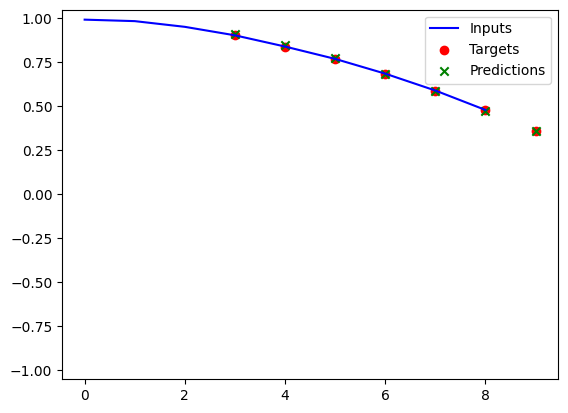

In [54]:
# Try it
test_display(seed = 5, dataloader = dataloader, model = model, device = device)

### What's next?

...